In [10]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

In [11]:
df = pd.read_csv('movie_df.csv', index_col=0)
df.shape

(1063, 12)

In [12]:
df.columns

Index(['Title', 'Distributor', 'Opening', 'Release_date', 'In_Release',
       'Rating', 'Run_time', 'Genre', 'Theatres', 'Domestic_gross',
       'Internation_gross', 'Worldwide_gross'],
      dtype='object')

In [13]:
df['Rating'] = df['Rating'].replace('None','Not Rated')
df['Rating'].value_counts()

R            396
PG-13        327
Not Rated    173
PG           158
G              9
Name: Rating, dtype: int64

In [34]:
#create dummy variables for 5 categories of movie rating
df.reset_index(inplace=True, drop=True)
dum = pd.get_dummies(df['Rating'])
df = pd.concat([df,dum],axis=1)
df.loc[1:2]

,Title,Distributor,Opening,Release_date,In_Release,Rating,Run_time,Genre,Theatres,Domestic_gross,...,Documentary,Drama,Horror,Other,Thriller,G,Not Rated,PG,PG-13,R
1,Uncharted,Sony Pictures Entertainment (SPE)See full comp...,114371180,"Feb 18, 2022",25 days/3 weeks,PG-13,116.0,Action,4275,114371180,...,0,0,0,0,0,0,0,0,1,0
2,Scream,Paramount PicturesSee full company information...,80987560,"Jan 14, 2022",60 days/8 weeks,R,114.0,Horror,3666,80987560,...,0,0,1,0,0,0,0,0,0,1


In [15]:
#get release year from str as int
df['Release_Yr'] = df['Release_date'].apply(lambda x: x.split('-')[0]).replace('\n','', regex=True)
df['Release_Yr'] = df['Release_Yr'].apply(lambda x: x.split()[2])
df['Release_Yr'] = pd.to_numeric(df['Release_Yr'])


In [16]:
#clean genre column
df['Genre'] = df['Genre'].apply(lambda x: x.split()[0])
df['Genre'] = df['Genre'].apply(lambda x: x.replace('[','').replace("'",'').replace(',','').replace(']',''))
genre = df['Genre'].value_counts()

#genre feature engineering
others = list(genre[genre < 10].index)
df['Genre'] = df['Genre'].replace(others, 'Other')
df['Genre'].value_counts()


Action         285
Drama          194
Comedy         164
Adventure      119
Biography      110
Crime           57
Horror          46
Documentary     42
Other           25
Animation       11
Thriller        10
Name: Genre, dtype: int64

In [35]:
#create dummy for genre column
genre_dum = pd.get_dummies(df['Genre'])
df = pd.concat([df,genre_dum],axis=1)
df.shape

(1063, 40)

In [39]:
df.columns

Index(['Title', 'Distributor', 'Opening', 'Release_date', 'In_Release',
       'Rating', 'Run_time', 'Genre', 'Theatres', 'Domestic_gross',
       'Internation_gross', 'Worldwide_gross', 'Release_Yr', 'Action',
       'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Horror', 'Other', 'Thriller', 'G', 'Not Rated', 'PG', 'PG-13',
       'R'],
      dtype='object')

In [40]:
df['Rating'].value_counts()

R            396
PG-13        327
Not Rated    173
PG           158
G              9
Name: Rating, dtype: int64

In [41]:
df['Genre'].value_counts()

Action         285
Drama          194
Comedy         164
Adventure      119
Biography      110
Crime           57
Horror          46
Documentary     42
Other           25
Animation       11
Thriller        10
Name: Genre, dtype: int64

In [42]:
#features vs. target
X = df.loc[:,['Run_time','Theatres','G','Not Rated','PG','PG-13','R',
             'Action','Adventure','Animation','Biography','Comedy','Crime','Documentary',
             'Drama','Horror','Thriller','Other']]
           
y = df['Domestic_gross']

In [43]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063 entries, 0 to 1062
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Run_time     1063 non-null   float64
 1   Theatres     1063 non-null   int64  
 2   G            1063 non-null   uint8  
 3   Not Rated    1063 non-null   uint8  
 4   PG           1063 non-null   uint8  
 5   PG-13        1063 non-null   uint8  
 6   R            1063 non-null   uint8  
 7   Action       1063 non-null   uint8  
 8   Adventure    1063 non-null   uint8  
 9   Animation    1063 non-null   uint8  
 10  Biography    1063 non-null   uint8  
 11  Comedy       1063 non-null   uint8  
 12  Crime        1063 non-null   uint8  
 13  Documentary  1063 non-null   uint8  
 14  Drama        1063 non-null   uint8  
 15  Horror       1063 non-null   uint8  
 16  Thriller     1063 non-null   uint8  
 17  Other        1063 non-null   uint8  
dtypes: float64(1), int64(1), uint8(16)
memory usage:

In [44]:
# Create and fit OLS regression model
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Domestic_gross   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     42.88
Date:                Tue, 22 Mar 2022   Prob (F-statistic):          9.81e-103
Time:                        18:12:50   Log-Likelihood:                -20645.
No. Observations:                1063   AIC:                         4.132e+04
Df Residuals:                    1046   BIC:                         4.141e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Run_time      3.72e+05   8.05e+04      4.624      0.000    2.14e+05     5.3e+05
Theatres     3.405e+04   1765.540     19.287      0.000    3.06e+04    3.75e+04
G           -1.249e+07   2.21e+07     -0.566      0.572   -5.58e+07    3.08e+07
Not Rated   -3.335e+07   8.37e+06     -3.983      0.000   -4.98e+07   -1.69e+07
PG          -4.512e+07   8.42e+06     -5.358      0.000   -6.17e+07   -2.86e+07
PG-13       -4.057e+07   7.56e+06     -5.365      0.000   -5.54e+07   -2.57e+07
R           -5.473e+07   7.04e+06     -7.777      0.000   -6.85e+07   -4.09e+07
Action      -8.514e+06   6.26e+06     -1.361      0.174   -2.08e+07    3.76e+06
Adventure   -1.181e+07   7.58e+06     -1.557      0.120   -2.67e+07    3.07e+06
Animation   -1.538e+07   1.92e+07     -0.801      0.424   -5.31e+07    2.23e+07
Biography   -1.856e+07   7.37e+06     -2.518      0.012    -3.3e+07    -4.1e+06
Comedy      -2.117e+07   6.22e+06     -3.402      0.001   -3.34e+07   -8.96e+06
Crime       -2.185e+07   9.54e+06     -2.290      0.022   -4.06e+07   -3.13e+06
Documentary -1.129e+07   1.01e+07     -1.115      0.265   -3.12e+07    8.58e+06
Drama       -2.242e+07   6.32e+06     -3.547      0.000   -3.48e+07      -1e+07
Horror      -1.553e+07   1.02e+07     -1.520      0.129   -3.56e+07    4.52e+06
Thriller    -7.329e+06      2e+07     -0.367      0.714   -4.65e+07    3.19e+07
Other       -3.243e+07   1.31e+07     -2.475      0.013   -5.81e+07   -6.72e+06
==============================================================================
Omnibus:                     1086.192   Durbin-Watson:                   0.652
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            61157.341
Skew:                           4.832   Prob(JB):                         0.00
Kurtosis:                      38.880   Cond. No.                     3.09e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.73e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

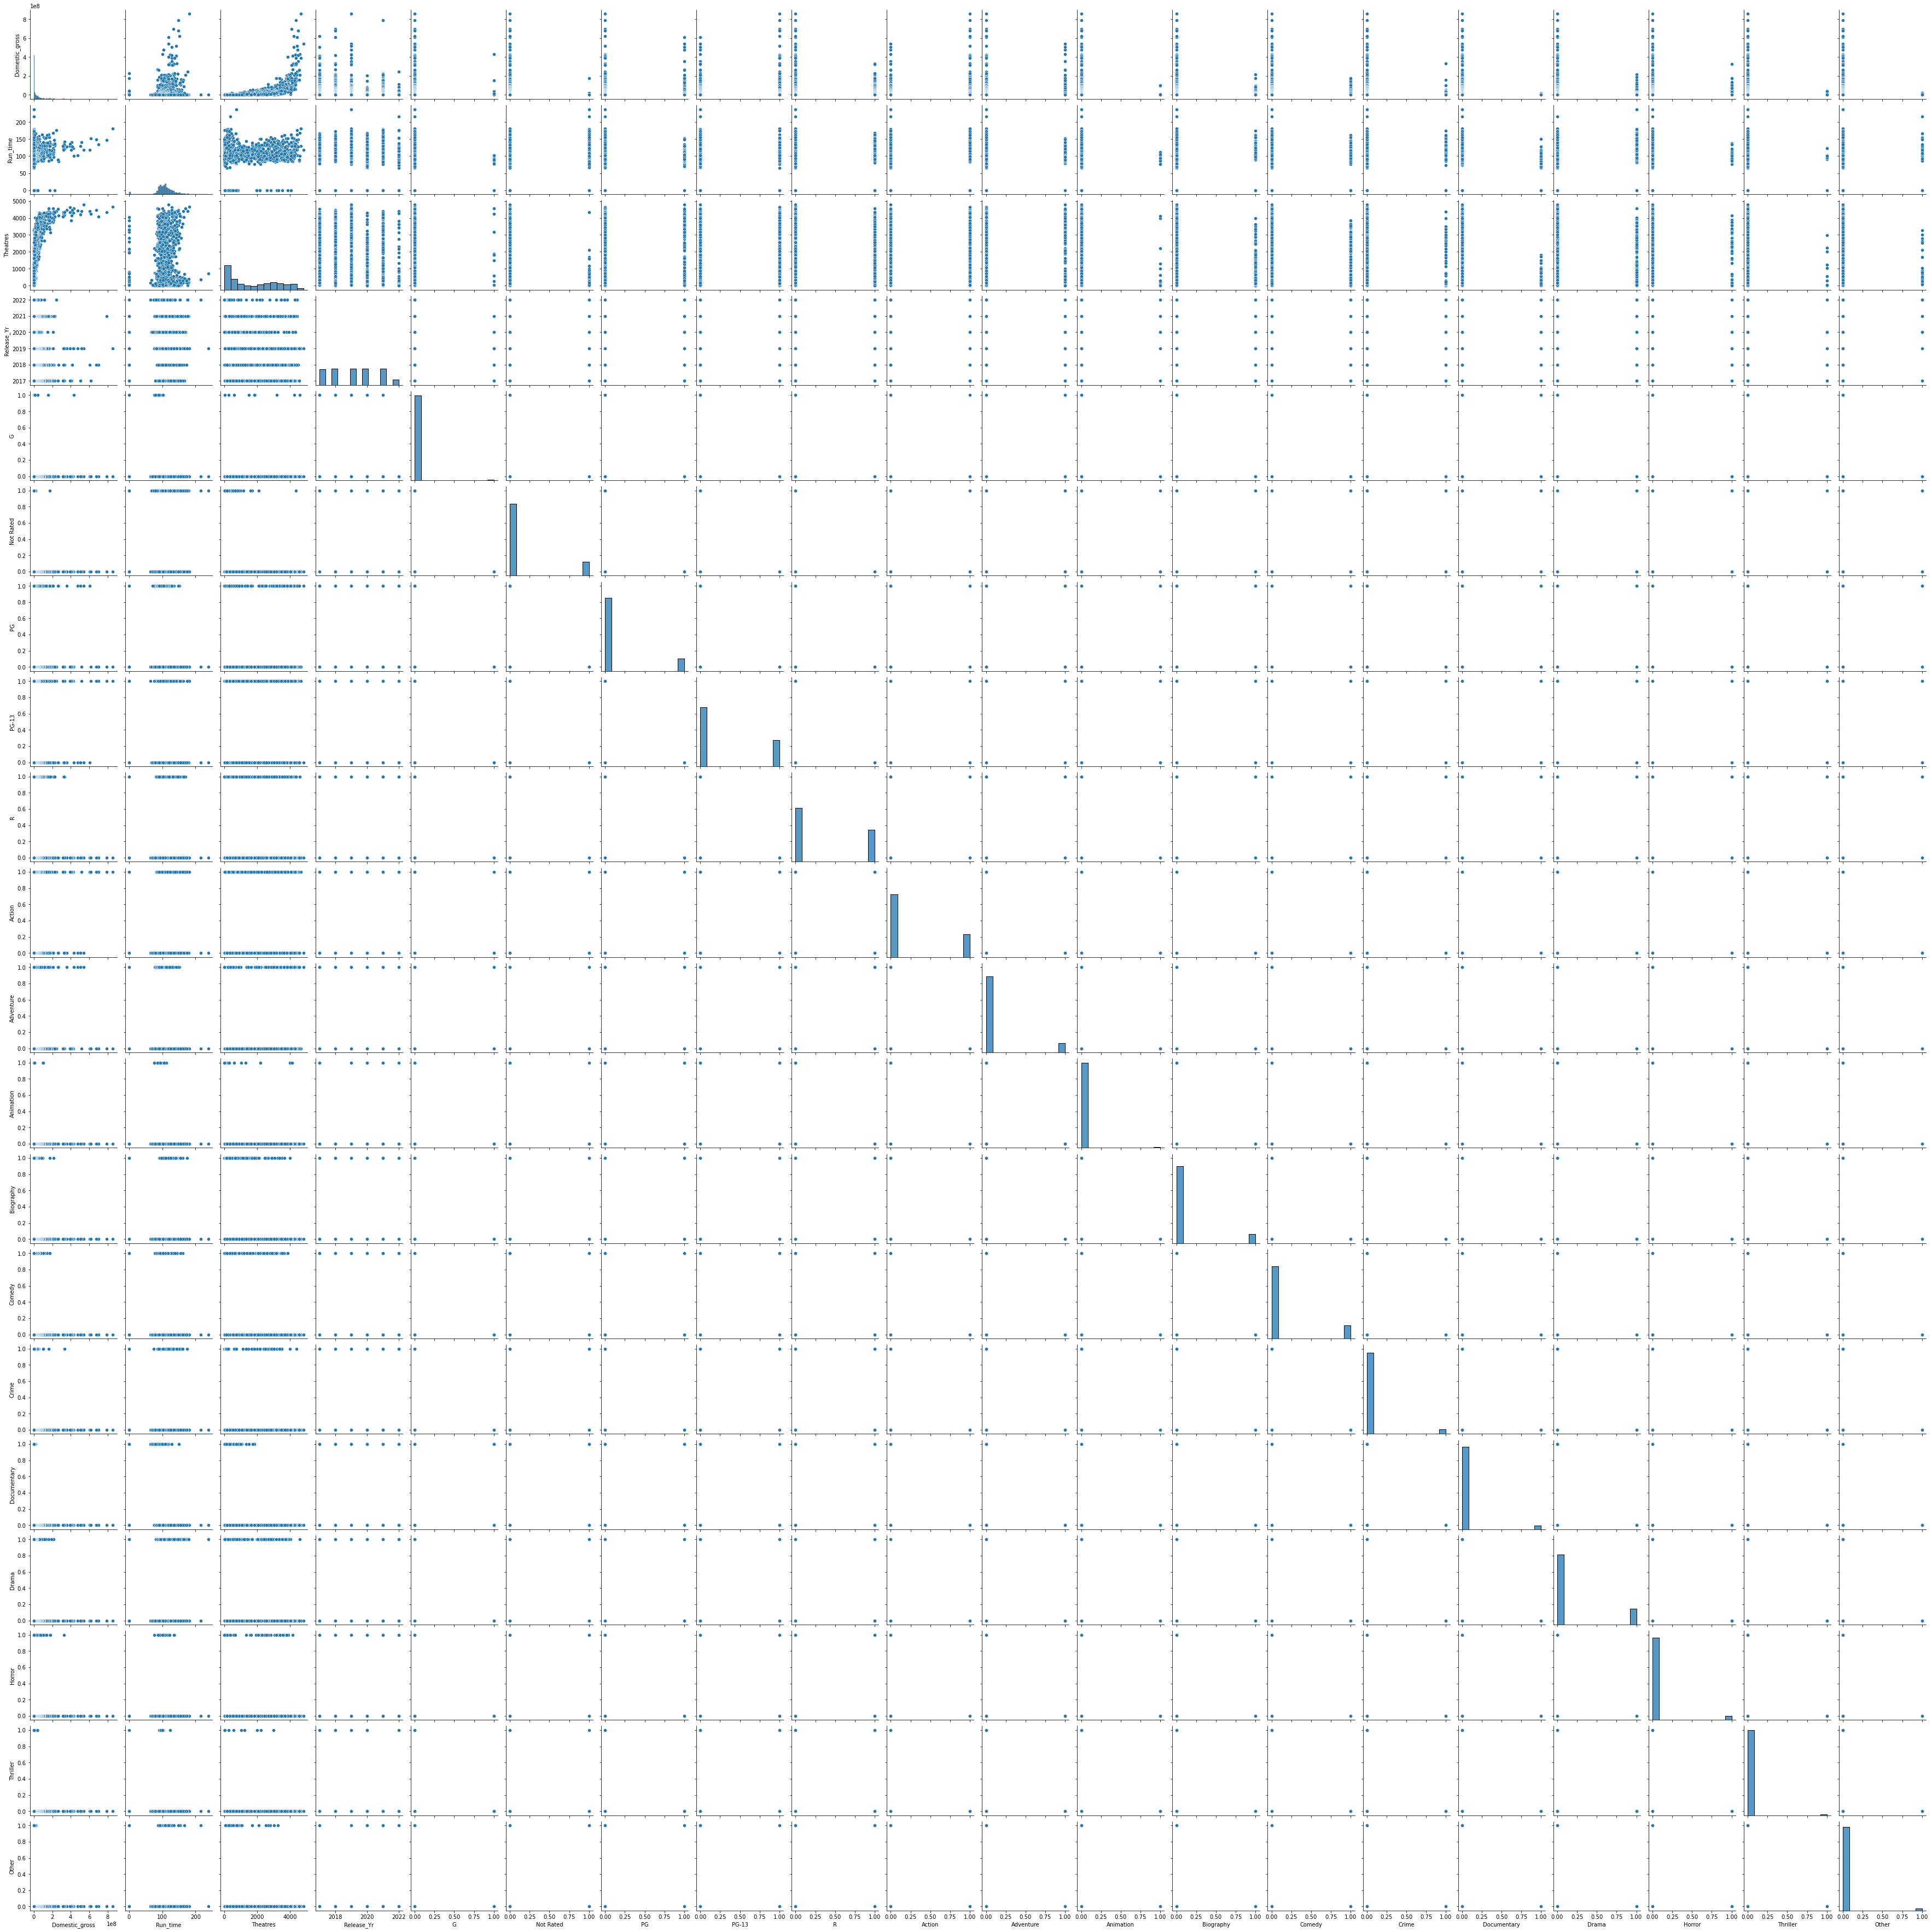

In [45]:
target_cols = df.loc[:,['Domestic_gross','Run_time','Theatres','Release_Yr','G','Not Rated','PG','PG-13','R',
             'Action','Adventure','Animation','Biography','Comedy','Crime','Documentary',
             'Drama','Horror','Thriller','Other']]
sns.pairplot(target_cols)

In [46]:
target_cols.corr()['Domestic_gross'].sort_values(ascending=False)

Domestic_gross    1.000000
Theatres          0.602790
Action            0.251973
PG-13             0.189295
Run_time          0.183072
Adventure         0.102470
PG                0.095983
G                 0.039544
Horror            0.010300
Animation        -0.022089
Thriller         -0.028478
Crime            -0.042079
Other            -0.060527
Documentary      -0.083718
Biography        -0.085316
Comedy           -0.086675
R                -0.116995
Drama            -0.126297
Not Rated        -0.185742
Release_Yr       -0.198578
Name: Domestic_gross, dtype: float64

In [47]:
#testing with linear regression, scalar regression(Deg 2 polynomial), and regularized linear regression
#splitting data into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=66)

linear_Re = LinearRegression()

#Feature scaling for ridge model
scaler = StandardScaler()

X_train_scale = scaler.fit_transform(X_train.values)
X_test_scale = scaler.transform(X_test.values)

linear_Re_Ridge = Ridge(alpha=1)

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_test_poly = poly.transform(X_test.values)

linear_Re_poly = LinearRegression()

In [48]:
linear_Re.fit(X_train, y_train)
print(f'Linear Regression test R^2: {linear_Re.score(X_test, y_test):.3f}')

linear_Re_Ridge.fit(X_train_scale, y_train)
print(f'Ridge Regression test R^2: {linear_Re_Ridge.score(X_test_scale, y_test):.3f}')

linear_Re_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {linear_Re_poly.score(X_test_poly, y_test):.3f}')

Linear Regression test R^2: 0.302
Ridge Regression test R^2: 0.302
Degree 2 polynomial regression val R^2: 0.507


In [49]:
#cross-validation testing with K-fold to determine best-fit model
kf_linearRe = KFold(n_splits=4, shuffle=True, random_state = 42)
cross_val_score(linear_Re, X, y, cv=kf_linearRe, scoring='r2')

array([0.36981509, 0.3690074 , 0.4224319 , 0.35160344])

In [50]:
kf_Ridge = KFold(n_splits=4, shuffle=True, random_state = 99)
cross_val_score(linear_Re_Ridge, X, y, cv=kf_Ridge, scoring='r2')

array([0.35766317, 0.38234202, 0.39562545, 0.39443105])

In [51]:
kf_Poly = KFold(n_splits=4, shuffle=True, random_state = 88)
cross_val_score(linear_Re_poly, X, y, cv=kf_Poly, scoring ='r2')

array([0.37231657, 0.45143911, 0.34078004, 0.36807212])

In [52]:
#new KFold partitioning
kf_same = KFold(n_splits=4, shuffle=True, random_state = 792)

print(np.mean(cross_val_score(linear_Re, X, y, cv=kf_same, scoring='r2')))
print(np.mean(cross_val_score(linear_Re_Ridge, X, y, cv=kf_same, scoring='r2')))
print(np.mean(cross_val_score(linear_Re_poly, X, y, cv=kf_same, scoring='r2')))
#indicates ridge regression performs a bit better

0.3807550008658059
0.38147859581636834
0.3807550008658059


In [53]:
#run ridge regression on data

linear_Re_Ridge.fit(X_train,y_train)
print(f'Ridge Regression test R^2: {linear_Re_Ridge.score(X_test, y_test):.3f}')

Ridge Regression test R^2: 0.302


Text(0, 0.5, 'Run Time')

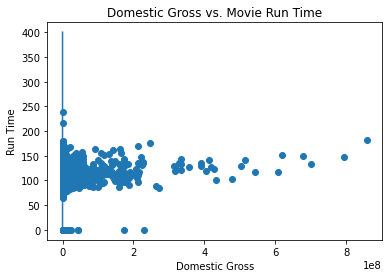

In [72]:
dom_gross_number = df['Domestic_gross']
feat_runtime = df['Run_time']

plt.scatter(dom_gross_number, feat_runtime)
plt.plot([0, 6000], [0, 400])
plt.title("Domestic Gross vs. Movie Run Time")
plt.xlabel("Domestic Gross")
plt.ylabel("Run Time")
#plt.savefig("Gross vs. Runtime.png")

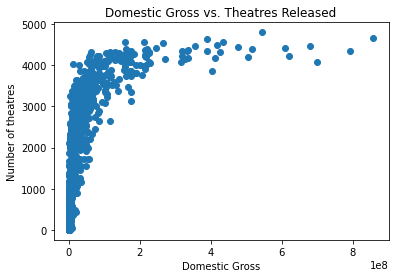

In [71]:
theatre_number = df['Theatres']

plt.scatter(dom_gross_number,theatre_number)
plt.plot([0, 400], [0, 400])
plt.title("Domestic Gross vs. Theatres Released")
plt.xlabel("Domestic Gross")
plt.ylabel("Number of theatres")
plt.savefig("Gross vs. theatre.png")